# Movie 6

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2

movie6_path = "movies/movie6.avi"

## Functions for detecting edges

In [4]:
# Detect edges with OpenCV's findContours
# No longer used
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

# Detect edges by detecting the first occurrence of a minimum rectangular section where the mean pixel values exceeds a threshold
# Threshold differs for different movies

# check_section is used to calibrate and find the right parameters for a movie
def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections


def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

In [5]:
# This cell was used to generate frames used to calibrate and test parameters  
#movie_path = "movies/movie6.avi"
#output_path = "movies/movie6"
#movie = cv2.VideoCapture(movie_path)
#count = 0
#while movie.isOpened():
#    count += 1
#    success, frame = movie.read()
#    if not success:
#        break
#    cv2.imwrite(f'{output_path}/frame{count}.jpg', frame)

#movie.release()
#cv2.destroyAllWindows()

In [6]:
# from skimage import io
# canvas = io.imread("movies/movie6/frame42.jpg")
# img = canvas[18:110,:350]

# plt.imshow(img)

In [15]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie6_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width, height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie6_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

data = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.zeros((frame.shape), np.uint8)
        canvas = frame[20:110, 0:355]
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 50, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        
        # Get trailing and leading bounding rectangle, and entire cell contour
        left_end = get_left_side(imgThreshold, check_size=3, min_mean_pixel=5)
        right_end = get_right_side(imgThreshold, check_size=5, min_mean_pixel=15)

        left_side_thickness = 30
        right_side_thickness = 30
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        right_section = imgThreshold[:, right_end-right_side_thickness:right_end+right_side_offset_correction]
        right_blur = cv2.blur(right_section, (10,10))
        _, right_thresh = cv2.threshold(right_blur, 170, 255, cv2.THRESH_BINARY)

        imgThreshold[:, right_end-right_side_thickness:right_end+right_side_offset_correction] = right_thresh

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

        bin_img = cv2.morphologyEx(imgThreshold,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)

        sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
        dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)
        
        ret, sure_fg = cv2.threshold(dist, 0.21 * dist.max(), 255, cv2.THRESH_BINARY)
        sure_fg = sure_fg.astype(np.uint8)

        unknown = cv2.subtract(sure_bg, sure_fg)

        ret, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0

        markers = cv2.watershed(canvas, markers)
        
        regions = []

        labels = np.unique(markers)
        left_segments = []
        right_segments = []
        left_color = [255,0,0]
        right_color = [255,255,0]
        
        edges = {
            "left":{
                "frame_index":frame_index,
                "count": 0,
                "mean": 0,
                "num_of_segments":0,
            },
            "right":{
                "frame_index":frame_index,
                "count": 0,
                "mean": 0,
                "num_of_segments":0,
            },
        }

        for label in labels[2:]:
        # Create a binary image in which only the area of the label is in the foreground 
        #and the rest of the image is in the background   
            target = np.where(markers == label, 255, 0).astype(np.uint8)
            x,y,w,h = cv2.boundingRect(target)

            min_segment_to_edge_distance = 10

            color = (255, 255, 255)
            if x-left_end <= min_segment_to_edge_distance:
                count, mean = get_mean_intensity(canvas[markers == label])
                edges["left"]["frame_index"] = frame_index
                edges["left"]["count"] += count
                edges["left"]["mean"] += mean
                edges["left"]["num_of_segments"] += 1
                
                canvas[markers == label] = left_color
                #cv2.putText(canvas, "L", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #left_segments.append((x,y,w,h))
            elif right_end-(w+x) <= min_segment_to_edge_distance:
                count, mean = get_mean_intensity(canvas[markers == label])
                edges["right"]["frame_index"] = frame_index
                edges["right"]["count"] += count
                edges["right"]["mean"] += mean
                edges["right"]["num_of_segments"] += 1

                canvas[markers == label] = right_color
                cv2.putText(canvas, f'{frame_index}', (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #right_segments.append((x,y,w,h))
            else:
                canvas[markers == label] = np.random.randint(0, 255, size=3)

        if edges["left"]["num_of_segments"] > 0:
            data.append([edges["left"]["frame_index"], "L", edges["left"]["count"], edges["left"]["mean"], edges["left"]["mean"]/edges["left"]["num_of_segments"], left_end])
        else:
            data.append([edges["left"]["frame_index"], "L", edges["left"]["count"], edges["left"]["mean"], edges["left"]["mean"]/1, left_end])
        if edges["right"]["num_of_segments"] > 0:
            data.append([edges["right"]["frame_index"], "R", edges["right"]["count"], edges["right"]["mean"], edges["right"]["mean"]/edges["right"]["num_of_segments"], left_end])
        else:
            data.append([edges["right"]["frame_index"], "R", edges["right"]["count"], edges["right"]["mean"], edges["right"]["mean"]/1, left_end])

        writer.write(canvas)
        cv2.imshow("Movie 6", canvas)

    else:
        break

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video


In [17]:
stimulation_start = 42
data_df = pd.DataFrame(data, columns = ["Frame", "Edge", "Intensity Count","Intensity","Average Intensity","Position"])
data_df["Displacement"] = data_df["Position"] - data_df["Position"][0]
data_df["Stimulated"] = data_df["Frame"] > stimulation_start
dummies = pd.get_dummies(data_df)
data_with_dummies_df = pd.concat([data_df, dummies[["Edge_L"]]], axis='columns')
cleaned_data = data_with_dummies_df.drop(['Edge'], axis='columns') * 1
right_edge_intensities = cleaned_data[cleaned_data["Edge_L"]==0]
right_edge_intensities

,Frame,Intensity Count,Intensity,Average Intensity,Position,Displacement,Stimulated,Edge_L
1,1,0,0.000000,0.000000,132,0,0,0
3,2,0,0.000000,0.000000,135,3,0,0
5,3,0,0.000000,0.000000,132,0,0,0
7,4,0,0.000000,0.000000,135,3,0,0
9,5,0,0.000000,0.000000,135,3,0,0
...,...,...,...,...,...,...,...,...
121,61,582,323.833059,107.944353,153,21,1,0
123,62,729,203.181326,101.590663,153,21,1,0
125,63,622,184.585248,92.292624,153,21,1,0
127,64,605,206.021195,103.010597,153,21,1,0


## Displacement

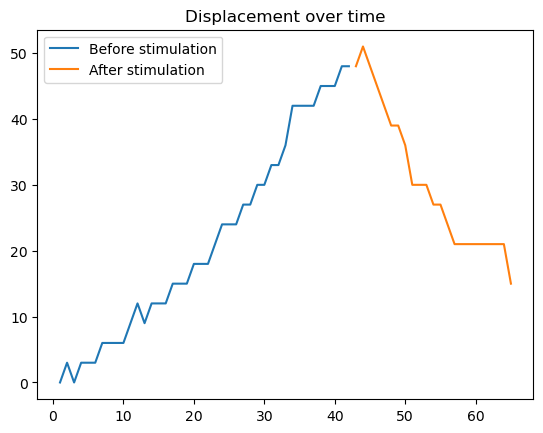

In [19]:
fig, ax = plt.subplots(1, sharex=False, sharey=False)

pre_stimulation = right_edge_intensities[right_edge_intensities["Stimulated"] == 0]
post_stimulation = right_edge_intensities[right_edge_intensities["Stimulated"] == 1]

X1 = pre_stimulation["Frame"]
X2 = post_stimulation["Frame"]
Y1 = pre_stimulation["Displacement"]
Y2 = post_stimulation["Displacement"]

ax.plot(X1, Y1)
ax.plot(X2, Y2)
ax.set_title("Displacement over time")

ax.legend(["Before stimulation","After stimulation"],loc='best')
plt.savefig("movie6_displacement_line_plot.png")
plt.show()

## Plot fluorescent intensity at right edge

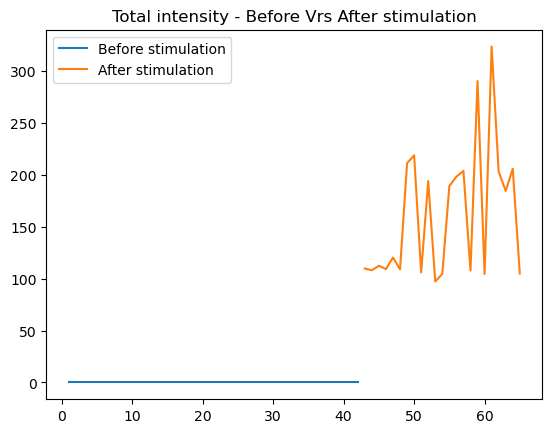

In [23]:
fig, ax = plt.subplots(1, sharex=False, sharey=False)

X1 = pre_stimulation["Frame"]
X2 = post_stimulation["Frame"]

Y1 = pre_stimulation["Intensity"]
Y2 = post_stimulation["Intensity"]

ax.plot(X1, Y1)
ax.plot(X2, Y2)
ax.set_title("Total intensity - Before Vrs After stimulation")

ax.legend(["Before stimulation","After stimulation"],loc='best')

plt.savefig("movie6_fluorescence_line_plot.png")
plt.show()

## Compare fluorescence before stimulation Vrs After stimulation

<Axes: xlabel='Stimulated', ylabel='Intensity'>

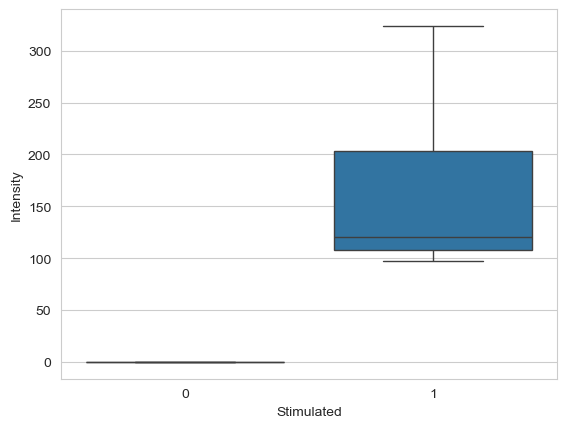

In [26]:
sns.set_style("whitegrid")
sns.boxplot(x = 'Stimulated', y = 'Intensity', data = right_edge_intensities)

## ANOVA of intensities at leading (right) edge before and after stimulation
- Since the leading edge (right side) intensity is the edge of interest in this particular case, lets perform an ANOVA test for both light stimulated and non-light stimulated frames

In [29]:
import scipy.stats as stats
stats.f_oneway(pre_stimulation["Intensity"], post_stimulation["Intensity"])

F_onewayResult(statistic=263.6236129906347, pvalue=3.405837241576024e-24)

- Fluorescent intensity significantly greater post-stimulation than pre-stimulation